In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

%matplotlib inline
import matplotlib.pyplot as plt

import skimage.transform
import sklearn.cross_validation
import pickle
import os

import cv2
import scipy.io
from scipy.ndimage.interpolation import rotate

import random
import scipy.misc
import matplotlib

from time import time

# Seed for reproducibility
np.random.seed(42)

whichmodel='resnet'

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


# define and load pretrained network

In [2]:
# Model definition for VGG-16, 16-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/211839e770f7b538e2d8

# More pretrained models are available from
# https://github.com/Lasagne/Recipes/blob/master/modelzoo/
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX

def build_model_vgg():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5) ##
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5) ##
    net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [3]:
#resnet

import lasagne
from lasagne.layers import InputLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import BatchNormLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import DenseLayer
from lasagne.nonlinearities import rectify, softmax


def build_simple_block(incoming_layer, names,
                       num_filters, filter_size, stride, pad,
                       use_bias=False, nonlin=rectify):
    """Creates stacked Lasagne layers ConvLayer -> BN -> (ReLu)
    Parameters:
    ----------
    incoming_layer : instance of Lasagne layer
        Parent layer
    names : list of string
        Names of the layers in block
    num_filters : int
        Number of filters in convolution layer
    filter_size : int
        Size of filters in convolution layer
    stride : int
        Stride of convolution layer
    pad : int
        Padding of convolution layer
    use_bias : bool
        Whether to use bias in conlovution layer
    nonlin : function
        Nonlinearity type of Nonlinearity layer
    Returns
    -------
    tuple: (net, last_layer_name)
        net : dict
            Dictionary with stacked layers
        last_layer_name : string
            Last layer name
    """
    net = []
    net.append((
            names[0],
            ConvLayer(incoming_layer, num_filters, filter_size, stride, pad,
                      flip_filters=False, nonlinearity=None) if use_bias
            else ConvLayer(incoming_layer, num_filters, filter_size, stride, pad, b=None,
                           flip_filters=False, nonlinearity=None)
        ))

    net.append((
            names[1],
            BatchNormLayer(net[-1][1])
        ))
    if nonlin is not None:
        net.append((
            names[2],
            NonlinearityLayer(net[-1][1], nonlinearity=nonlin)
        ))

    return dict(net), net[-1][0]


def build_residual_block(incoming_layer, ratio_n_filter=1.0, ratio_size=1.0, has_left_branch=False,
                         upscale_factor=4, ix=''):
    """Creates two-branch residual block
    Parameters:
    ----------
    incoming_layer : instance of Lasagne layer
        Parent layer
    ratio_n_filter : float
        Scale factor of filter bank at the input of residual block
    ratio_size : float
        Scale factor of filter size
    has_left_branch : bool
        if True, then left branch contains simple block
    upscale_factor : float
        Scale factor of filter bank at the output of residual block
    ix : int
        Id of residual block
    Returns
    -------
    tuple: (net, last_layer_name)
        net : dict
            Dictionary with stacked layers
        last_layer_name : string
            Last layer name
    """
    simple_block_name_pattern = ['res%s_branch%i%s', 'bn%s_branch%i%s', 'res%s_branch%i%s_relu']

    net = {}

    # right branch
    net_tmp, last_layer_name = build_simple_block(
        incoming_layer, map(lambda s: s % (ix, 2, 'a'), simple_block_name_pattern),
        int(lasagne.layers.get_output_shape(incoming_layer)[1]*ratio_n_filter), 1, int(1.0/ratio_size), 0)
    net.update(net_tmp)

    net_tmp, last_layer_name = build_simple_block(
        net[last_layer_name], map(lambda s: s % (ix, 2, 'b'), simple_block_name_pattern),
        lasagne.layers.get_output_shape(net[last_layer_name])[1], 3, 1, 1)
    net.update(net_tmp)

    net_tmp, last_layer_name = build_simple_block(
        net[last_layer_name], map(lambda s: s % (ix, 2, 'c'), simple_block_name_pattern),
        lasagne.layers.get_output_shape(net[last_layer_name])[1]*upscale_factor, 1, 1, 0,
        nonlin=None)
    net.update(net_tmp)

    right_tail = net[last_layer_name]
    left_tail = incoming_layer

    # left branch
    if has_left_branch:
        net_tmp, last_layer_name = build_simple_block(
            incoming_layer, map(lambda s: s % (ix, 1, ''), simple_block_name_pattern),
            int(lasagne.layers.get_output_shape(incoming_layer)[1]*4*ratio_n_filter), 1, int(1.0/ratio_size), 0,
            nonlin=None)
        net.update(net_tmp)
        left_tail = net[last_layer_name]

    net['res%s' % ix] = ElemwiseSumLayer([left_tail, right_tail], coeffs=1)
    net['res%s_relu' % ix] = NonlinearityLayer(net['res%s' % ix], nonlinearity=rectify)

    return net, 'res%s_relu' % ix


def build_model_resnet():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    sub_net, parent_layer_name = build_simple_block(
        net['input'], ['conv1', 'bn_conv1', 'conv1_relu'],
        64, 7, 2, 3, use_bias=True)
    net.update(sub_net)
    net['pool1'] = PoolLayer(net[parent_layer_name], pool_size=3, stride=2, pad=0, mode='max', ignore_border=False)
    block_size = list('abc')
    parent_layer_name = 'pool1'
    for c in block_size:
        if c == 'a':
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1, 1, True, 4, ix='2%s' % c)
        else:
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='2%s' % c)
        net.update(sub_net)

    block_size = list('abcd')
    for c in block_size:
        if c == 'a':
            sub_net, parent_layer_name = build_residual_block(
                net[parent_layer_name], 1.0/2, 1.0/2, True, 4, ix='3%s' % c)
        else:
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='3%s' % c)
        net.update(sub_net)

    block_size = list('abcdef')
    for c in block_size:
        if c == 'a':
            sub_net, parent_layer_name = build_residual_block(
                net[parent_layer_name], 1.0/2, 1.0/2, True, 4, ix='4%s' % c)
        else:
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='4%s' % c)
        net.update(sub_net)

    block_size = list('abc')
    for c in block_size:
        if c == 'a':
            sub_net, parent_layer_name = build_residual_block(
                net[parent_layer_name], 1.0/2, 1.0/2, True, 4, ix='5%s' % c)
        else:
            sub_net, parent_layer_name = build_residual_block(net[parent_layer_name], 1.0/4, 1, False, 4, ix='5%s' % c)
        net.update(sub_net)
    net['pool5'] = PoolLayer(net[parent_layer_name], pool_size=7, stride=1, pad=0,
                             mode='average_exc_pad', ignore_border=False)
    net['fc1000'] = DenseLayer(net['pool5'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc1000'], nonlinearity=softmax)

    return net

In [4]:
#!wget -N https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/resnet50.pkl

In [5]:
# Load model weights and metadata
if whichmodel=='vgg':
    d = pickle.load(open('vgg16.pkl'))
    net = build_model_vgg()
    lasagne.layers.set_all_param_values(net['prob'], d['param values'])
elif whichmodel=='resnet':
    d = pickle.load(open('resnet50.pkl'))
    net = build_model_resnet()
    lasagne.layers.set_all_param_values(net['prob'], d['values'])
else:
    raise Exception('invalid model')
#d = pickle.load(open('vgg_finetuned_ARC2017_rotation_2_augmented_exceptcolor_2.pkl'))

# load training data

In [6]:
# The network expects input in a particular format and size.
# We define a preprocessing function to load a file and apply the necessary transformations

def prep_image_rot_stage(stack,offset=70): #process np file for images taken from rotation stage
    #load a stack of np files with multiple rotational images of the same object from the same view
    #stack is _ by dim1 by dim2 by 3
    #take a variance projection, threshold, and find the smallest bounding box
    #return truncated stack, resized to _x3x224x224, the same processing as done in prep_image
    #offset changes the vertical offset of the bounding box
    
    varproj=np.var(stack,0)[:,:,0] #only need to look at one channel
    mask=varproj>np.mean(varproj)*.99 #where is there motion?
    
    #find bounding box
    #because there are outliers due to camera defects, I find the median of the thresholded points
    #and take the bounding box as 2x the stdev
    c=np.nonzero(mask)
    c1=np.int32(np.median(c[1]))
    c0=np.int32(np.median(c[0]))-offset
    sig1=np.int32(np.std(c[1])*2)
    sig0=np.int32(np.std(c[0])*2)
    sig=np.max([sig1,sig0]) #take the larger sig, construct square
    
    #bounding box extremes
    low0=c0-sig
    high0=c0+sig
    low1=c1-sig
    high1=c1+sig
    if low0<0: #if offset goes negative, readjust
        high0-=low0
        low0=0
    
    stack_new=[skimage.transform.resize(im,(224,224)) for im in stack[:,low0:high0,low1:high1]]
    stack_new=np.stack(stack_new,0)
    #stack_raw=np.copy(stack_new)
    
    # Shuffle axes to c01
    stack_new=np.swapaxes(np.swapaxes(stack_new, 2, 3), 1, 2)
    
    # Convert to BGR
    stack_new=stack_new[:,::-1, :, :]# - np.expand_dims(IMAGE_MEAN,0)
    
    return stack_new#,stack_raw

def deprocess(im,RGB=True):
    #by default, input im is BGR
    
    if RGB:
        im = im[::-1, :, :]
    im = np.swapaxes(np.swapaxes(im, 0, 1), 1, 2)
        
    #im = (im - im.min())
    #im = im / im.max()
    return im

In [7]:
#for the second ARC rotation dataset
directory='/home/kevin/Documents/ARC/ARC2017_rotation2/'
imlist_by_group=list() #list of stacks of images, where each stack is for one object at one view

projection_images=list() #there are 80 of these; projection of all images from a single rotation per camera
y=list() #labels for groups (80)
for subdir in os.walk(directory): #first get the folders, which contain different classes of images
    dir_=subdir[0]
    #get the class label
    cls=dir_.partition('rotation2/')[-1]
    if not cls or 'point_cloud' in cls: #if it's empty (the root directory); point cloud folder is empty
        continue
    aligned=list() #rgb with depth mask
    aligned_numbers=list()
    rgb=list()
    rgb_numbers=list()
    for im in os.listdir(dir_):
        if 'point_cloud' in im:
            continue
        number=int(im.partition('image_')[-1][:-4]) #extract number from name, e.g. image_6058.npy --> 6058
        if 'aligned' in im:
            aligned.append((number,np.load(dir_+'/'+im)))
            aligned_numbers.append(number)
        else:
            rgb.append((number,np.load(dir_+'/'+im))) #twice as many images, because aligned and non aligned
            rgb_numbers.append(number)
    aligned=sorted(aligned)
    aligned_numbers=sorted(aligned_numbers)
    rgb=sorted(rgb)
    rgb_numbers=sorted(rgb_numbers)
    
    #separate rgb into the two camera views:
    view0=[i[1] for i in rgb if i[0] in aligned_numbers]
    view1=[i[1] for i in rgb if i[0] not in aligned_numbers]
    
    if not view0 or not view1:
        print 'empty directory: '+dir_
        continue
    
    X0 = np.stack(view0).astype(np.float32)
    X0proj=np.round(np.mean(X0,0))
    #plt.imshow(-X0proj)
    #plt.show()
    
    X1 = np.stack(view1).astype(np.float32)
    X1proj=np.round(np.mean(X1,0))
    #plt.imshow(-X1proj)
    #plt.show()
    
    #projection_images.append(X0proj)
    #projection_images.append(X1proj)
    
    imlist_by_group.append(X0)
    imlist_by_group.append(X1)
    y.append(cls)
    y.append(cls)
    print dir_
#projection_images=np.stack(projection_images)

/home/kevin/Documents/ARC/ARC2017_rotation2/Poland_Spring_Water
/home/kevin/Documents/ARC/ARC2017_rotation2/Table_Cloth
/home/kevin/Documents/ARC/ARC2017_rotation2/Hinged_Ruled_Index_Cards
/home/kevin/Documents/ARC/ARC2017_rotation2/Hand_Weight
/home/kevin/Documents/ARC/ARC2017_rotation2/Tennis_Ball_Container
/home/kevin/Documents/ARC/ARC2017_rotation2/Bath_Sponge
/home/kevin/Documents/ARC/ARC2017_rotation2/White_Facecloth
/home/kevin/Documents/ARC/ARC2017_rotation2/Band_Aid_Tape
/home/kevin/Documents/ARC/ARC2017_rotation2/Speed_Stick
/home/kevin/Documents/ARC/ARC2017_rotation2/Glue_Sticks
/home/kevin/Documents/ARC/ARC2017_rotation2/Burts_Bees_Baby_Wipes
/home/kevin/Documents/ARC/ARC2017_rotation2/Avery_Binder
/home/kevin/Documents/ARC/ARC2017_rotation2/Ticonderoga_Pencils
/home/kevin/Documents/ARC/ARC2017_rotation2/Flashlight
/home/kevin/Documents/ARC/ARC2017_rotation2/Plastic_Wine_Glass
/home/kevin/Documents/ARC/ARC2017_rotation2/Marbles
/home/kevin/Documents/ARC/ARC2017_rotation2/Bl

In [8]:
# #save in matlab format for manual segmentation
# import scipy.io
# scipy.io.savemat('ARC2017_rotation2_projection_images.mat',{'projection_images':projection_images})

In [9]:
#input is image, 3,224,224 and a class number, output is same image with added background object/noise
def addBackgroundObject(image, classnum):
    #swap axes
    image_swap = np.swapaxes(image, 0,1)
    image_swap = np.swapaxes(image_swap, 1,2)

    #get a random class
    rand_class = [x for x in range(40) if x!=classnum and x!=12] #fiskar scissors missign
    random.shuffle(rand_class)
    rand_class = rand_class[0]
    
    #try to load in an image from that random class
    try:
        rand_imgs = np.load('/home/kevin/Documents/ARC/cropped_rotation_fromBK/cropped_images' + str(rand_class) + '.npy')
    except:
        print("Unable to load in random image for class {}. Returning".format(rand_class))
        return image
    
    rand_img = [x for x in range(len(rand_imgs))]
    random.shuffle(rand_img)
    rand_img = rand_imgs[rand_img[0]]
    
    #create a new image the same size as the old one
    result = np.zeros((1024,1024,3)).astype('uint8')
    #convert old image to bw
    bw_img = cv2.cvtColor(np.swapaxes(image,0,2),cv2.COLOR_BGR2GRAY)
    #find the border pts
    _,borderpts,_ = cv2.findContours(bw_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    #randomly rotate the bg image
    rand_img = scipy.misc.imrotate(rand_img, random.randint(0,360))
    
    #random border pt
    rand_border_pt = random.randint(0,len(borderpts[0])-1)
    #stored as y,x
    rand_border_pt = borderpts[0][rand_border_pt][0] 
    

    w = rand_img.shape[1]
    h = rand_img.shape[0]
    centerX = rand_img.shape[1]//2
    centerY = rand_img.shape[0]//2
    
    t = centerY-h//2
    b = centerY+h//2
    l = centerX-w//2
    r = centerX+w//2


    #find how much we should use of the bg image
    bg_right = rand_border_pt[1] + w//2
    bg_left = rand_border_pt[1] - w//2
    bg_top = rand_border_pt[0] - h//2
    bg_bot = rand_border_pt[0] + h//2
    
    #order 
    if bg_right < bg_left:
        bg_right, bg_left = bg_left, bg_right

    if bg_bot < bg_top:
        bg_top, bg_bot = bg_bot, bg_top

    #paste the random image in first at a random boundary pt
    result[400+bg_top:400+bg_bot, 400+bg_left:400+bg_right,:] = rand_img[t:b, l:r, :]
    
    result[400:624, 400:624, 0] = np.where(image_swap[:,:, 0]!= 0, image_swap[:, :, 0], result[400:624, 400:624, 0])
    result[400:624, 400:624, 1] = np.where(image_swap[:,:, 1]!= 0, image_swap[:, :, 1], result[400:624, 400:624, 1])
    result[400:624, 400:624, 2] = np.where(image_swap[:,:, 2]!= 0, image_swap[:, :, 2], result[400:624, 400:624, 2])
    
    res = result[400:624, 400:624]

    #swap axes back
    res = np.swapaxes(res, 1, 2)
    res = np.swapaxes(res, 0, 1)

    return res
def get_segmented_images(imlist,box_coords):
    #imlist is a list of stacks of images, by object and view
    #box_coords is the corresponding coordinates to segment out the objects
    
    imlist_segmented=list()
    for stack,coords in zip(imlist,box_coords):
        (y,x,l,w)=np.round(coords).astype(np.int32)
        imlist_segmented.append(stack[:,x:x+w,y:y+l,:])
    return imlist_segmented

def generate_augmented_dataset(imlist,labels,upscale_factor=1,smallest_dim=80,max_translate=40,
                               brightness_scale_range=[.999,1.001],max_skew=.3): 
    #imlist is the output of get_segmented_images; i.e., it is a list of stacks for each object for both views
    #this function detects the size and accordingly (de)magnifies the image, translates it, and rotates it
    
    #the output image size is 224x224 to match VGG net
    #each raw segmented image will be resized from a range such that the largest dimension will be at most 224
    #on the other extreme,the largest dimension will be no smaller than smallest_dim in pixels
    #upscale_factor: how many replicates of each raw image to include (with random transformations)
    #images will also be randomly rotated, color dithered, and randomly translated in a small region near the center
    #max_translate is the maximum distance in pixels to decenter the image in one direction (plus or minus)
    #brightness scale range specifies the max and min possible multiplicative factor of the L channel in 
    #HSL 
    #random crops are generated by generating a random box size with same aspect ratio as the original image
    #but side lengths are scaled between .5 and 1.0 (to guarantee that no more than half othe image is occluded)
    
    X=list()
    y=list()
    for stack,y_ in zip(imlist,labels):
        h,w=stack.shape[1:3] #dimensions of the segmented image
        #X_=list()
        for im in stack: #all images in a stack share the same bounding box
            for _ in xrange(upscale_factor): #for each image, do multiple random augmentation operations
                #random crop:
                rawim=np.copy(im)
                h,w,_=rawim.shape
                h_center=h/2
                w_center=w/2

                h_scale=1#np.random.rand(1)*.5+.5
                w_scale=1#np.random.rand(1)*.5+.5
                h_new=int(h*h_scale) #side lengths of the box to sample from the original image
                w_new=int(w*w_scale)

                mask=np.zeros((h,w,1))

                #pick random numbers for translating the box crop 
                h_trans=int((np.random.rand(1)-.5)*(h-h_new))
                w_trans=int((np.random.rand(1)-.5)*(w-w_new))
                h_center+=h_trans
                w_center+=w_trans
                mask[h_center-h_new/2:h_center+h_new/2,w_center-w_new/2:w_center+w_new/2,0]=1.
                rawim*=mask

                #rotate image randomly:
                #for opencv, the image is the same dimensions, so cropping occurs after rotation
                randangle=np.random.rand(1)[0]*360
                #M = cv2.getRotationMatrix2D((w/2,h/2),int(randangle),1)
                #rawim = cv2.warpAffine(rawim,M,(w,h))
                rawim=rotate(rawim,randangle,order=1) #scipy.ndimage.interpolation; this version doesn't crop
                h,w,_=rawim.shape #new shape
                
#                 #random shear
#                 case=np.random.choice(4)
#                 #only shear one dim (if you shear both dims, you might get rotation ...; also more annoying to correct field of view)
#                 #case 0: positive horizontal
#                 #case 1: negative horizontal
#                 #case 2: positive vertical
#                 #case 3: negative vertical
#                 factor=np.random.rand(1)[0]*max_skew
#                 if case==0: #need to resize the image after skewing
#                     rawim=cv2.warpAffine(rawim,np.array([[1.,factor,0],[0,1,0]]),(np.int32(w+factor*h),h))
#                 if case==1:
#                     rawim=cv2.warpAffine(rawim,np.array([[1.,-factor,np.int32(factor*h)],[0,1,0]]),(np.int32(w+factor*h),h))
#                 if case==2:
#                     rawim=cv2.warpAffine(rawim,np.array([[1.,0,0],[factor,1,0]]),(w,np.int32(w*factor+h)))
#                 if case==3:
#                     rawim=cv2.warpAffine(rawim,np.array([[1.,0,0],[-factor,1,np.int32(factor*w)]]),(w,np.int32(w*factor+h)))

                
#                 h,w,_=rawim.shape #new shape

                #rescale image
                pix_rescale=np.random.rand(1)[0]*(224-smallest_dim)+smallest_dim #number of pixels to rescale to
                newim=np.zeros((224,224,3))
                if h>w:
                    dim1=pix_rescale.astype(np.int32)
                    dim2=(pix_rescale*w/h).astype(np.int32)
                else:
                    dim1=(pix_rescale*h/w).astype(np.int32)
                    dim2=pix_rescale.astype(np.int32)

                #generate random translation:
                dx,dy=np.random.rand((2))
                dx=int((dx-.5)*2*max_translate)
                dy=int((dy-.5)*2*max_translate)

                #create new image
                rawim = skimage.transform.resize(rawim, (dim1,dim2), preserve_range=True)
                #safeguard against translating out of the field of view:
                lowx=np.maximum(112-dim1/2+dx,0)
                highx=np.minimum(112+(dim1-dim1/2+dx),224)
                lowy=np.maximum(112-dim2/2+dy,0)
                highy=np.minimum(112+(dim2-dim2/2)+dy,224)
                rawim=rawim[:highx-lowx,:highy-lowy]
                newim[lowx:highx,
                      lowy:highy]=rawim

                #random brightness scaling (note; if using opencv, have to convert to 8-bit):
                rand_scale=np.random.rand(1)*(brightness_scale_range[1]-brightness_scale_range[0])+brightness_scale_range[0]
                im2=cv2.cvtColor(newim.astype(np.uint8),cv2.COLOR_RGB2HLS)
                im2[:,:,1]=np.maximum(np.minimum(im2[:,:,1]*rand_scale,255),0) #squeeze between 0 and 255
                newim=cv2.cvtColor(im2,cv2.COLOR_HLS2RGB)

                #process the formatting of the image:
                # Shuffle axes to c01
                newim = np.swapaxes(np.swapaxes(newim, 1, 2), 0, 1)

                #ADD RANDOM BACKGROUND (from brenton); note that the background and foreground don't get same lighting
                #newim=addBackgroundObject(newim,LABELS[y_])

                # Convert to BGR
                newim = newim[::-1, :, :]

                X.append(newim[np.newaxis])
                y.append(y_)
        print y_ #print current progress
    return X,y

In [10]:
#import from matlab
box_coords=np.round(
    scipy.io.loadmat(
        'ARC2017_rotation2_projection_SEGMENTATION.mat')['box_coords']).astype(np.int32)
#get labels and numbering
CLASSES=np.sort(os.listdir('/home/kevin/Documents/ARC/Training items/'))
LABELS = {cls: i for i, cls in enumerate(CLASSES)}

segmented=get_segmented_images(imlist_by_group,box_coords)
X,y=generate_augmented_dataset(segmented,y,smallest_dim=200,brightness_scale_range=[.99,1.01])

Poland_Spring_Water
Poland_Spring_Water
Table_Cloth
Table_Cloth
Hinged_Ruled_Index_Cards
Hinged_Ruled_Index_Cards
Hand_Weight
Hand_Weight
Tennis_Ball_Container
Tennis_Ball_Container
Bath_Sponge
Bath_Sponge
White_Facecloth
White_Facecloth
Band_Aid_Tape
Band_Aid_Tape
Speed_Stick
Speed_Stick
Glue_Sticks
Glue_Sticks
Burts_Bees_Baby_Wipes
Burts_Bees_Baby_Wipes
Avery_Binder
Avery_Binder
Ticonderoga_Pencils
Ticonderoga_Pencils
Flashlight
Flashlight
Plastic_Wine_Glass
Plastic_Wine_Glass
Marbles
Marbles
Black_Fashion_Gloves
Black_Fashion_Gloves
Laugh_Out_Loud_Jokes
Laugh_Out_Loud_Jokes
Scotch_Sponges
Scotch_Sponges
Balloons
Balloons
Expo_Eraser
Expo_Eraser
Ice_Cube_Tray
Ice_Cube_Tray
Toilet_Brush
Toilet_Brush
Reynolds_Wrap
Reynolds_Wrap
Colgate_Toothbrush_4PK
Colgate_Toothbrush_4PK
Epsom_Salts
Epsom_Salts
Irish_Spring_Soap
Irish_Spring_Soap
Robots_DVD
Robots_DVD
Hanes_Socks
Hanes_Socks
Mesh_Cup
Mesh_Cup
Crayons
Crayons
Pie_Plates
Pie_Plates
Tissue_Box
Tissue_Box
Mouse_Traps
Mouse_Traps
Measurin

In [11]:
imlist_by_group=None
segmented=None
X_tr=np.vstack(X).astype(np.float32)
print X_tr.shape
y=np.hstack(y)

y_tr=np.array([LABELS[i] for i in y]).astype('int32')

(8750, 3, 224, 224)


# or, load Amazon's images

In [12]:
#load amazon's provided images

directory='/home/kevin/Documents/ARC/Training items/'

imlist_by_group=list()
y_=list() #classes
for subdir in os.listdir(directory):
    path=directory+subdir
    
    files=next(os.walk(path))[2] #files in the directory for the class corresponding to subdir
    
    current_class=list() #list of images from current class
    for f in files:
        if f[-3:]=='png': #load the png images
            im=cv2.imread(path+'/'+f)[:,:,::-1]#.astype(np.uint8)
            resized=skimage.transform.resize(im, (512,512), preserve_range=True)
            current_class.append(resized) #*255 because the images are 0 to 1
            #current_class.append(im[60:2940,60:2940]) #some images differ in size
    
    imlist_by_group.append(np.stack(current_class))
    y_.append(subdir)
    print subdir

Poland_Spring_Water
Table_Cloth
Hinged_Ruled_Index_Cards
Hand_Weight
Tennis_Ball_Container
Bath_Sponge
White_Facecloth
Band_Aid_Tape
Speed_Stick
Glue_Sticks
Burts_Bees_Baby_Wipes
Avery_Binder
Ticonderoga_Pencils
Flashlight
Plastic_Wine_Glass
Marbles
Black_Fashion_Gloves
Laugh_Out_Loud_Jokes
Scotch_Sponges
Balloons
Expo_Eraser
Ice_Cube_Tray
Toilet_Brush
Reynolds_Wrap
Colgate_Toothbrush_4PK
Epsom_Salts
Irish_Spring_Soap
Robots_DVD
Hanes_Socks
Mesh_Cup
Crayons
Pie_Plates
Tissue_Box
Fiskars_Scissors
Mouse_Traps
Measuring_Spoons
Composition_Book
Robots_Everywhere
Duct_Tape
Windex


In [13]:
CLASSES=np.sort(os.listdir('/home/kevin/Documents/ARC/Training items/'))
LABELS = {cls: i for i, cls in enumerate(CLASSES)}
X_,y_=generate_augmented_dataset(imlist_by_group,y_,
                               smallest_dim=200,
                               brightness_scale_range=[.99,1.01],
                               max_translate=1,
                               upscale_factor=16)

#imlist_by_group=None
X_tr_=np.vstack(X_).astype(np.float32)
print X_tr_.shape
y_=np.hstack(y_)

y_tr_=np.array([LABELS[i] for i in y_]).astype('int32')

Poland_Spring_Water
Table_Cloth
Hinged_Ruled_Index_Cards
Hand_Weight
Tennis_Ball_Container
Bath_Sponge
White_Facecloth
Band_Aid_Tape
Speed_Stick
Glue_Sticks
Burts_Bees_Baby_Wipes
Avery_Binder
Ticonderoga_Pencils
Flashlight
Plastic_Wine_Glass
Marbles
Black_Fashion_Gloves
Laugh_Out_Loud_Jokes
Scotch_Sponges
Balloons
Expo_Eraser
Ice_Cube_Tray
Toilet_Brush
Reynolds_Wrap
Colgate_Toothbrush_4PK
Epsom_Salts
Irish_Spring_Soap
Robots_DVD
Hanes_Socks
Mesh_Cup
Crayons
Pie_Plates
Tissue_Box
Fiskars_Scissors
Mouse_Traps
Measuring_Spoons
Composition_Book
Robots_Everywhere
Duct_Tape
Windex
(3744, 3, 224, 224)


In [14]:
#merge datasets
X_tr=np.vstack([X_tr[0:-1:2],X_tr_])
y_tr=np.hstack([y_tr[0:-1:2],y_tr_])

# load validation data (manual segmentations)

In [15]:
def load_validation_set(directory,numimages):
    #load a list of segmented images from a specified directory
    #numimages is the number of images that were manually segmented
    def get_image_segments(im,segment_coords):
        #given inputs, returns segmented image 
        #object coordinates:
        xy=np.array(segment_coords)

        #isolate the object
        mask=np.zeros_like(im)
        mask[xy[:,1],xy[:,0]]=1
        masked=im*mask

        #coordinates of corners of the bounding box (unrotated)
        x1,y1=np.min(xy,0)
        x2,y2=np.max(xy,0)

        segment=masked[y1:y2,x1:x2]
        #plt.imshow(segment)
        return segment

    all_segments=list()
    all_labels=list()
    for i in xrange(numimages):
        #load data for an image
        try: #either cam1 or cam2
            im=np.load(directory+'/image_cam1_'+str(i)+'.npy')
            flag='1' #indicates which cam to load from next
        except:
            im=np.load(directory+'/image_cam2_'+str(i)+'.npy')
            flag='2'
        try: #segment vs seg in name
            segments=np.load(directory+'/image_cam'+flag+'_'+str(i)+'_seg.npy')
        except:
            segments=np.load(directory+'/image_cam'+flag+'_'+str(i)+'_segmented.npy')   
        labels=np.load(directory+'/image_cam'+flag+'_'+str(i)+'_labels.npy')

        for (lab,seg) in zip(labels,segments):
            if seg: #if not empty:
                all_labels.append(lab)
                all_segments.append(get_image_segments(im,seg))
            else:
                print 'image '+str(i)+' has an empty segmentation!'

    return all_segments,all_labels

def put_validation_segments_on_black_bkgd(segment):
    #create a blanks canvas of size 224by224
    #if the segment is too large, resize the largest dimension to 224
    #no augmentations (e.g., rotations, translations, etc.)
    h,w,_=segment.shape
    if h>224:
        w=int(w*224./h)
        h=224
    if w>224:
        h=int(h*224./w)
        w=224

    #create new image
    segment = skimage.transform.resize(segment, (h,w), preserve_range=True)
    
    newim=np.zeros((224,224,3))
    newim[112-h/2:112-h/2+h,112-w/2:112-w/2+w]=segment
    
    #process the formatting of the image:
    # Shuffle axes to c01
    newim = np.swapaxes(np.swapaxes(newim, 1, 2), 0, 1)

    # Convert to BGR
    newim = newim[::-1, :, :]
    
    return newim[np.newaxis]


In [16]:
#load validation set
directory='/home/kevin/Documents/ARC/Manual segmentation/tote_shelf_top_down/tote_shelf1'
(segments1,labels1)=load_validation_set(directory,12)
directory='/home/kevin/Documents/ARC/Manual segmentation/tote_shelf_top_down/tote_shelf2'
(segments2,labels2)=load_validation_set(directory,64)
labels=labels1+labels2
segments=segments1+segments2

#get labels and numbering
X_val=list()
for segment in segments:
    X_val.append(put_validation_segments_on_black_bkgd(segment))
    
CLASSES=np.sort(os.listdir('/home/kevin/Documents/ARC/Training items/'))
LABELS = {cls: i for i, cls in enumerate(CLASSES)}
y_val=np.array([LABELS[i] for i in labels]).astype('int32')
X_val = np.vstack(X_val).astype(np.float32)

image 39 has an empty segmentation!


# define optimization computational graph

In [17]:
# We'll connect our output classifier to the last fully connected layer of the network
if whichmodel=='vgg':
    output_layer = DenseLayer(net['fc7'], num_units=len(CLASSES), nonlinearity=softmax)
elif whichmodel=='resnet':
    output_layer = DenseLayer(net['fc1000'], num_units=len(CLASSES), nonlinearity=softmax)
else:
    raise Exception('invalid method')

In [18]:
# #freeze all but last layer parameters, if desired
# for layer in lasagne.layers.get_all_layers(output_layer):
#     if layer is not output_layer:
#         for param in layer.params:
#             layer.params[param].discard('trainable')

In [19]:
# if loading a finetuned net
#output_layer=net['prob']

In [20]:
# Define loss function and metrics, and get an updates dictionary
X_sym = T.tensor4()
y_sym = T.ivector()

prediction = lasagne.layers.get_output(output_layer, X_sym)
loss = lasagne.objectives.categorical_crossentropy(prediction, y_sym)
loss = loss.mean()

#weight decay:
from lasagne.regularization import regularize_layer_params, l2
l2_penalty = regularize_layer_params(output_layer, l2)
lam=2e-3
loss = loss + lam*l2_penalty

params = lasagne.layers.get_all_params(output_layer, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.0001, momentum=0.9)

#deterministic versions for prediction
deterministic_prediction=lasagne.layers.get_output(output_layer, X_sym,deterministic=True)
acc = T.mean(T.eq(T.argmax(deterministic_prediction, axis=1), y_sym),
                      dtype=theano.config.floatX)
deterministic_loss=lasagne.objectives.categorical_crossentropy(deterministic_prediction, y_sym).mean()

In [21]:
# Compile functions for training, validation and prediction
train_fn = theano.function([X_sym, y_sym], loss, updates=updates)
val_fn = theano.function([X_sym, y_sym], [loss, acc])
pred_fn = theano.function([X_sym], deterministic_prediction)

# train network

In [22]:
# generator splitting an iterable into chunks of maximum length N
def batches(iterable, N):
    chunk = []
    for item in iterable:
        chunk.append(item)
        if len(chunk) == N:
            yield chunk
            chunk = []
    if chunk:
        yield chunk
def train_batch():
    ix = range(len(y_tr))
    np.random.shuffle(ix)
    ix = ix[:BATCH_SIZE]
    return train_fn(X_tr[ix], y_tr[ix]),y_tr[ix] #also return which classes chosen

# We need a fairly small batch size to fit a large network like this in GPU memory
BATCH_SIZE = 32

In [23]:
#training code

#store how many times the network saw each object for each epoch
class_counts=list()

for epoch in range(30):
    start=time()
    class_count_epoch=list()
    for batch in range(25):
        loss,class_count = train_batch()
        for i in class_count: #store class id for each epoch
            class_count_epoch.append(i)
    class_counts.append(class_count_epoch)
    
    ix = range(len(y_val))
    np.random.shuffle(ix)

    loss_tot = 0.
    acc_tot = 0.
    for chunk in batches(ix, BATCH_SIZE):
        loss, acc = val_fn(X_val[chunk], y_val[chunk])
        loss_tot += loss * len(chunk)
        acc_tot += acc * len(chunk)

    loss_tot /= len(ix)
    acc_tot /= len(ix)
    print(epoch, loss_tot, acc_tot * 100,time()-start)

(0, 4.9584227811427635, 4.0816326558258185, 38.071187019348145)
(1, 3.9916622598892242, 10.946196666011563, 38.10878801345825)
(2, 3.4351820764382386, 21.150278298664624, 38.08487915992737)
(3, 3.0350304972484072, 29.870129881188245, 38.46179699897766)
(4, 2.7426698592686698, 36.549165142710443, 38.38172912597656)
(5, 2.5488262379987785, 41.558441580558309, 37.95892000198364)
(6, 2.3355797987037334, 46.011131670125557, 38.258780002593994)
(7, 2.2623260521048296, 50.6493506272339, 37.87374401092529)
(8, 2.1334493275254909, 50.649350594058774, 37.87615609169006)
(9, 2.0850399818845053, 55.844155833097467, 37.798907995224)
(10, 2.0385280659557052, 56.029684733813681, 37.733417987823486)
(11, 1.983770665963196, 57.51391478947231, 37.805630922317505)
(12, 1.9415907196299707, 57.884972082219456, 38.04830193519592)
(13, 1.875302080763072, 57.699443435845879, 37.874003887176514)
(14, 1.8968836898485231, 58.441558574258949, 37.78961896896362)
(15, 1.8573720154381861, 60.66790359139663, 37.77546

# store trained network

In [32]:
import copy
d_updated=copy.deepcopy(d)
_=d_updated.pop('synset words',None)
updated_params=list()
for i in params: #get new parameter values
    updated_params.append(np.array(i.eval()))

In [34]:
#d_updated['param values']=updated_params
d_updated['values']=updated_params

In [35]:
pickle.dump(d_updated,open("resnet_finetuned_05262017.pkl","wb"))

# analyze network results

0.814471243043
0.656771799629


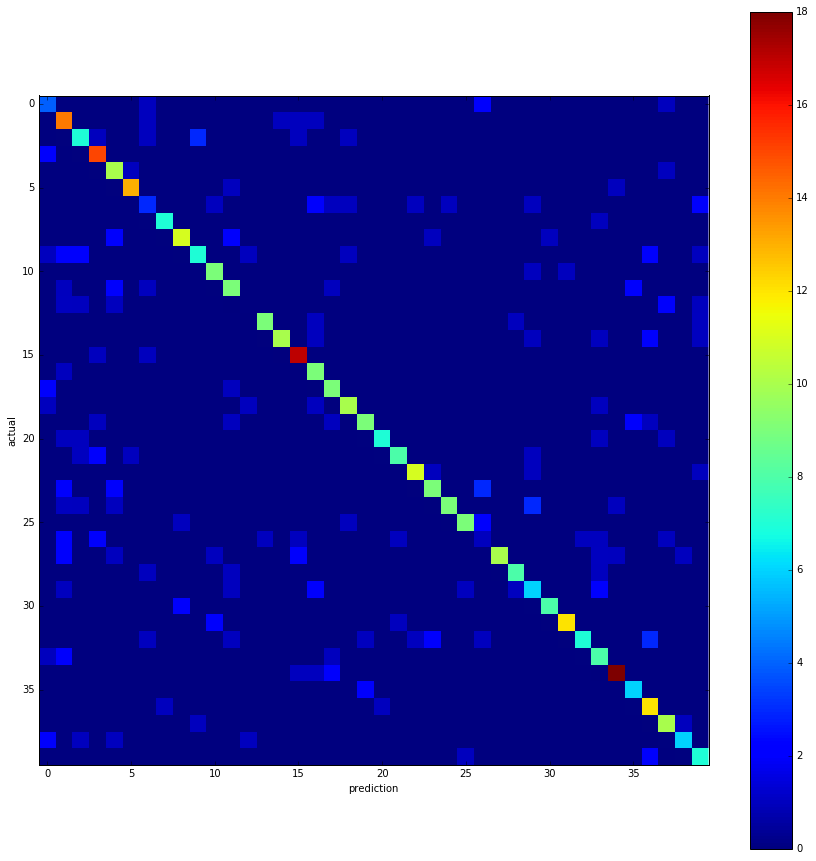

In [24]:
#compute top-k accuracy
matches=list() #list of 0s and 1s to indicate whether there is a top k match
preds=list() #list of predictions
k=3
BATCH_SIZE=32
ix = range(len(y_val))
for chunk in batches(ix, BATCH_SIZE):
    p_y=pred_fn(X_val[chunk]).argsort()[:,-k:][:,::-1]
    for i in xrange(len(chunk)):
        matches.append(y_val[chunk][i] in p_y[i])
        preds.append(p_y[i][0]) #store the top prediction

print np.mean(matches) #top-k accuracy
print np.mean(np.array(preds)==y_val) #accuracy

#confusion matrix
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(y_val,preds,labels=range(40))    

plt.figure(figsize=(15,15))
plt.imshow(conf,interpolation='none')
plt.xlabel('prediction')
plt.ylabel('actual')
plt.colorbar()
plt.show()

In [25]:
#plot accuracy by class
correct=np.diagonal(conf)
colsum=np.sum(conf,0)
rowsum=np.sum(conf,1)
class_acc=np.round(correct*1.0/rowsum,3) #of all the objects in a class, how many does the network get right?
prediction_acc=np.round(correct*1.0/colsum,3) #of all the guesses for a class, how many does the network get right?

print 'by class|by guess'
for (cls,corr,col,row) in zip(CLASSES,correct,colsum,rowsum):
    print str(corr)+'/'+str(row)+'\t'+str(corr)+'/'+str(col)+'\t'+cls

by class|by guess
5/8	5/10	Avery_Binder
17/18	17/65	Balloons
6/14	6/11	Band_Aid_Tape
15/17	15/35	Bath_Sponge
5/12	5/20	Black_Fashion_Gloves
12/15	12/13	Burts_Bees_Baby_Wipes
2/13	2/8	Colgate_Toothbrush_4PK
6/8	6/7	Composition_Book
12/17	12/13	Crayons
8/17	8/21	Duct_Tape
7/11	7/9	Epsom_Salts
8/16	8/14	Expo_Eraser
1/6	1/3	Fiskars_Scissors
9/12	9/11	Flashlight
13/16	13/20	Glue_Sticks
11/19	11/11	Hand_Weight
5/10	5/13	Hanes_Socks
1/12	1/1	Hinged_Ruled_Index_Cards
8/14	8/10	Ice_Cube_Tray
10/15	10/17	Irish_Spring_Soap
7/11	7/7	Laugh_Out_Loud_Jokes
9/13	9/16	Marbles
9/14	9/13	Measuring_Spoons
10/16	10/13	Mesh_Cup
8/16	8/11	Mouse_Traps
9/13	9/12	Pie_Plates
0/11	0/3	Plastic_Wine_Glass
8/19	8/9	Poland_Spring_Water
6/11	6/8	Reynolds_Wrap
6/14	6/14	Robots_DVD
8/10	8/9	Robots_Everywhere
9/15	9/11	Scotch_Sponges
7/17	7/9	Speed_Stick
2/12	2/3	Table_Cloth
17/22	17/19	Tennis_Ball_Container
7/8	7/15	Ticonderoga_Pencils
13/14	13/20	Tissue_Box
7/12	7/12	Toilet_Brush
2/11	2/2	White_Facecloth
9/10	9/21	Wind

'Irish_Spring_Soap'

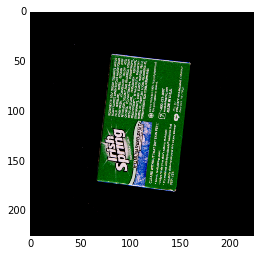

In [40]:
i=-800
plt.imshow(deprocess(X_tr[i]).astype(np.uint8))
CLASSES[y_tr[i]]

In [25]:
np.mean(X_val[X_val>0])

123.50881

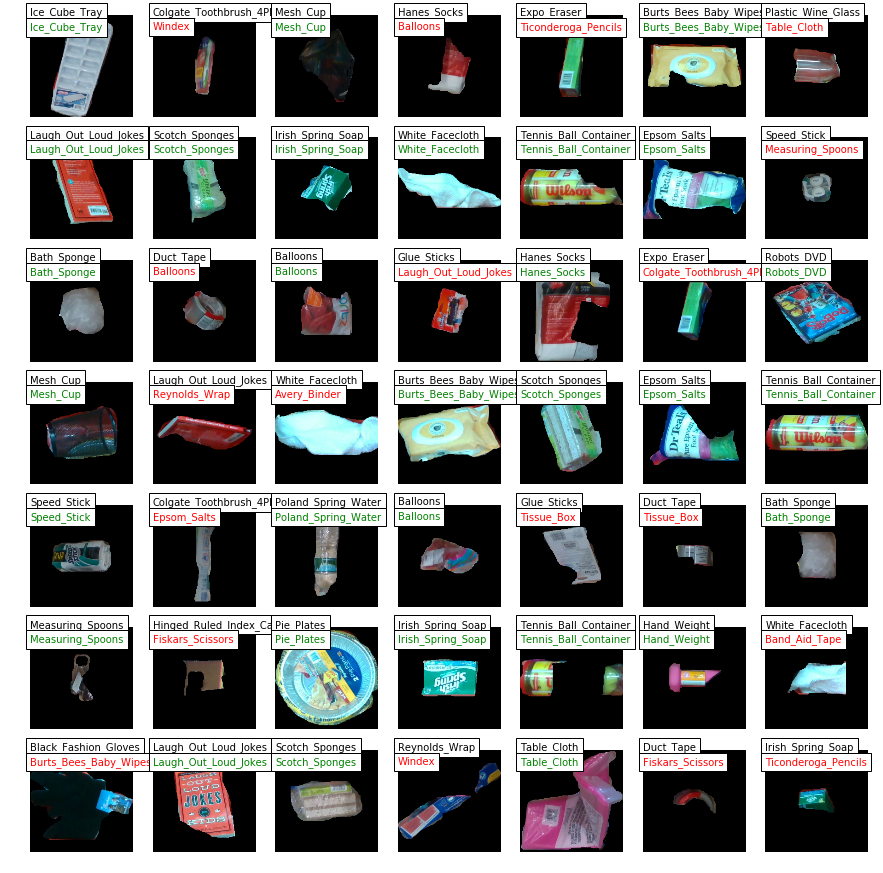

In [31]:
# Plot some results from the validation set
p_y = pred_fn(X_val[:49]).argmax(-1)

plt.figure(figsize=(15, 15))
for i in range(0, 49):
    plt.subplot(7, 7, i+1)
    plt.imshow(deprocess(X_val[i]).astype(np.uint8))
    true = y_val[i]
    pred = p_y[i]
    color = 'green' if true == pred else 'red'
    plt.text(0, 0, CLASSES[true], color='black', bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 32, CLASSES[pred], color=color, bbox=dict(facecolor='white', alpha=1))

    plt.axis('off')

In [ ]:
im=np.copy(X[0:1]).astype(np.uint8)#.astype(np.float32)
im=np.swapaxes(im,2,3)
plt.imshow(deprocess(im[0]))
best5=pred_fn(im)[0].argsort()[-5:]
for i in best5:
    print i

In [20]:
LABELS

{'Avery_Binder': 0,
 'Balloons': 1,
 'Band_Aid_Tape': 2,
 'Bath_Sponge': 3,
 'Black_Fashion_Gloves': 4,
 'Burts_Bees_Baby_Wipes': 5,
 'Colgate_Toothbrush_4PK': 6,
 'Composition_Book': 7,
 'Crayons': 8,
 'Duct_Tape': 9,
 'Epsom_Salts': 10,
 'Expo_Eraser': 11,
 'Fiskars_Scissors': 12,
 'Flashlight': 13,
 'Glue_Sticks': 14,
 'Hand_Weight': 15,
 'Hanes_Socks': 16,
 'Hinged_Ruled_Index_Cards': 17,
 'Ice_Cube_Tray': 18,
 'Irish_Spring_Soap': 19,
 'Laugh_Out_Loud_Jokes': 20,
 'Marbles': 21,
 'Measuring_Spoons': 22,
 'Mesh_Cup': 23,
 'Mouse_Traps': 24,
 'Pie_Plates': 25,
 'Plastic_Wine_Glass': 26,
 'Poland_Spring_Water': 27,
 'Reynolds_Wrap': 28,
 'Robots_DVD': 29,
 'Robots_Everywhere': 30,
 'Scotch_Sponges': 31,
 'Speed_Stick': 32,
 'Table_Cloth': 33,
 'Tennis_Ball_Container': 34,
 'Ticonderoga_Pencils': 35,
 'Tissue_Box': 36,
 'Toilet_Brush': 37,
 'White_Facecloth': 38,
 'Windex': 39}

In [ ]:
class ModifiedBackprop(object):

    def __init__(self, nonlinearity):
        self.nonlinearity = nonlinearity
        self.ops = {}  # memoizes an OpFromGraph instance per tensor type

    def __call__(self, x):
        # OpFromGraph is oblique to Theano optimizations, so we need to move
        # things to GPU ourselves if needed.
        if theano.sandbox.cuda.cuda_enabled:
            maybe_to_gpu = theano.sandbox.cuda.as_cuda_ndarray_variable
        else:
            maybe_to_gpu = lambda x: x
        # We move the input to GPU if needed.
        x = maybe_to_gpu(x)
        # We note the tensor type of the input variable to the nonlinearity
        # (mainly dimensionality and dtype); we need to create a fitting Op.
        tensor_type = x.type
        # If we did not create a suitable Op yet, this is the time to do so.
        if tensor_type not in self.ops:
            # For the graph, we create an input variable of the correct type:
            inp = tensor_type()
            # We pass it through the nonlinearity (and move to GPU if needed).
            outp = maybe_to_gpu(self.nonlinearity(inp))
            # Then we fix the forward expression...
            op = theano.OpFromGraph([inp], [outp])
            # ...and replace the gradient with our own (defined in a subclass).
            op.grad = self.grad
            # Finally, we memoize the new Op
            self.ops[tensor_type] = op
        # And apply the memoized Op to the input we got.
        return self.ops[tensor_type](x)
class GuidedBackprop(ModifiedBackprop):
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
        dtype = inp.dtype
        return (grd * (inp > 0).astype(dtype) * (grd > 0).astype(dtype),)
    
def compile_saliency_function():
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    inp = net['input'].input_var
    outp = lasagne.layers.get_output(output_layer, deterministic=True)
    max_outp = T.max(outp, axis=1)
    saliency = theano.grad(max_outp.sum(), wrt=inp)
    max_class = T.argmax(outp, axis=1)
    return theano.function([inp], [saliency, max_class])

def compile_saliency_function_arbitrary_class():
    #the function outputted by this def takes in both an image and a class
    class_num_var=T.scalar(dtype='int32')
    
    inp = net['input'].input_var
    outp = lasagne.layers.get_output(output_layer, deterministic=True)
    outp_class=outp[0,class_num_var]
    saliency = theano.grad(outp_class, wrt=inp)
    return theano.function([inp,class_num_var], [saliency])

def show_images(img_original, saliency, max_class, title):
    # get out the first map and class from the mini-batch
    saliency = saliency[0]
    max_class = max_class[0]
    # convert saliency from BGR to RGB, and from c01 to 01c
    saliency = saliency[::-1].transpose(1, 2, 0)
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.suptitle("Class: " + CLASSES[max_class] + ". Saliency: " + title)
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(img_original)
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency).max(axis=-1), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.show()

In [ ]:
relu = lasagne.nonlinearities.rectify
relu_layers = [layer for layer in lasagne.layers.get_all_layers(output_layer)
               if getattr(layer, 'nonlinearity', None) is relu]
#modded_relu = GuidedBackprop(relu)  # important: only instantiate this once!
for layer in relu_layers:
    layer.nonlinearity = modded_relu
    
saliency_fn = compile_saliency_function()

In [ ]:
saliency_fn_var = compile_saliency_function_arbitrary_class()

In [ ]:
i=142
im=X_val[i:i+1]
class_num=np.array([0]).astype(np.int32)
saliency = saliency_fn_var(im,class_num[0])
show_images(deprocess(im[0]).astype(np.uint8), saliency[0], class_num, "guided backprop")

In [ ]:
saliency[0].shape

In [ ]:
i=142
im=X_val[i:i+1]
#im=np.roll(im,-50,3)
saliency, max_class = saliency_fn(im)
show_images(deprocess(im[0]).astype(np.uint8), saliency, max_class, "guided backprop")

In [ ]:
plt.imshow(X[0,0])
plt.colorbar()